In [23]:
import re

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
train_df = pd.read_csv('data/train.csv')
train_df.shape

(159571, 8)

In [3]:
test_df = pd.read_csv('data/test.csv')
test_df.shape

(153164, 2)

In [4]:
labels_df = pd.read_csv('data/test_labels.csv')
labels_df.shape

(153164, 7)

In [5]:
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [6]:
labels_df.groupby('toxic')['id'].count()

toxic
-1    89186
 0    57888
 1     6090
Name: id, dtype: int64

In [11]:
labels_df[labels_df['toxic'] > -1].count()

id               63978
toxic            63978
severe_toxic     63978
obscene          63978
threat           63978
insult           63978
identity_hate    63978
dtype: int64

For this project, I'll throw out the unlabeled examples (-1), and combine the train and remaining test examples. Then I'll analyze the full dataset before splitting again 80/20.

In [13]:
labeled_test_df = test_df.merge(labels_df, on='id', how='inner')
labeled_test_df = labeled_test_df[labeled_test_df['toxic'] > -1]

full_df = pd.concat([train_df, labeled_test_df], axis=0).reset_index(drop=True)
full_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


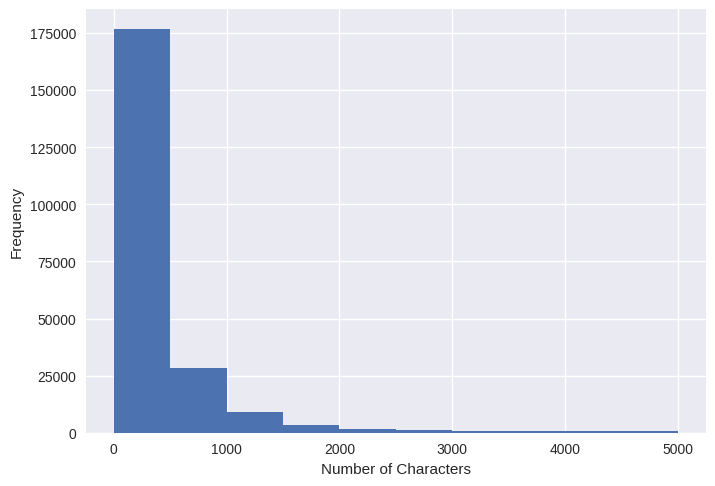

In [24]:
lens = full_df['comment_text'].str.len()
ax = lens.plot(kind='hist')
ax.set_xlabel('Number of Characters');
plt.savefig('results/eda/character_lengths.png')

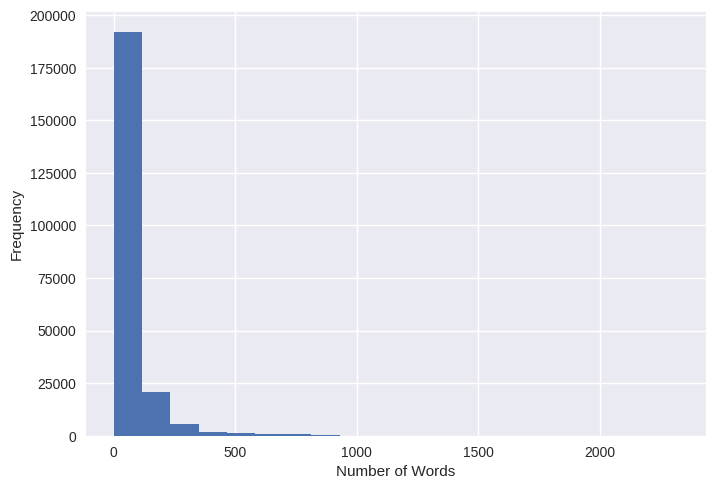

In [31]:
word_lens = full_df['comment_text'].apply(lambda x: len(x.split()))
ax = word_lens.plot(kind='hist', bins=20)
ax.set_xlabel('Number of Words')
plt.savefig('results/eda/word_counts.png')

In [26]:
(lens < 500).mean()

0.7895360748650184

In [42]:
(word_lens < 500).mean()

0.9869335134578996

In [16]:
full_df.groupby('toxic')['id'].count()

toxic
0    202165
1     21384
Name: id, dtype: int64

In [17]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat',
          'insult', 'identity_hate']
full_df['all'] = full_df.apply(lambda x: sum([x[l] for l in labels]), axis=1)

In [18]:
tmp = full_df.groupby('all')['id'].count()
tmp / tmp.sum()

all
0    0.899494
1    0.036690
2    0.022411
3    0.028137
4    0.010606
5    0.002460
6    0.000201
Name: id, dtype: float64

In [19]:
full_df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,all
count,223549.000000,223549.000000,223549.000000,223549.000000,223549.000000,223549.000000,223549.000000
mean,0.095657,0.008777,0.054306,0.003082,0.050566,0.009470,0.221857
std,0.294121,0.093272,0.226621,0.055431,0.219110,0.096852,0.754190
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000


In [20]:
full_df[labels].sum()

toxic            21384
severe_toxic      1962
obscene          12140
threat             689
insult           11304
identity_hate     2117
dtype: int64

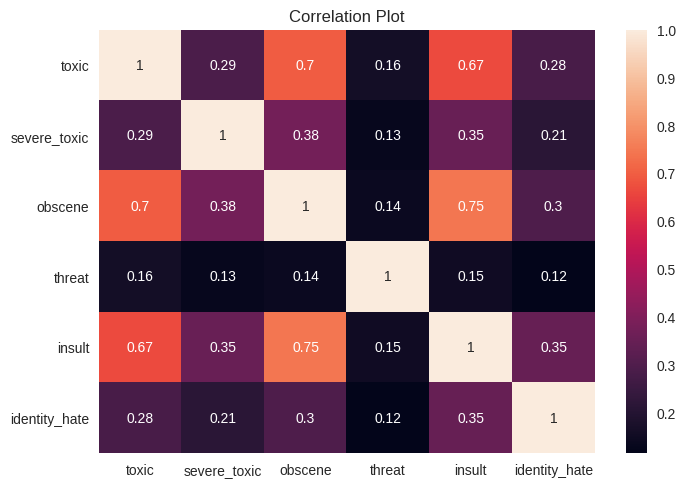

In [41]:
def histogram_intersection(a, b):
    v = np.minimum(a, b).sum().round(decimals=1)
    return v

ax = sns.heatmap(full_df[labels].corr(method='pearson'), annot=True)
ax.set_title('Correlation Plot')
plt.savefig('results/eda/label_correlations.png')

## Is amount of punctuation correlated with any labels?

In [16]:
full_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,all
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0


In [ ]:
def pct_punctuation(text):
    return len(re.findall('[^a-zA-Z0-9 ]', text)) / len(text)

full_df['pct_punctuation'] = full_df['comment_text'].apply(pct_punctuation)

In [ ]:
for label in labels:
    print(label, full_df[full_df[label] == 1]['pct_punctuation'].mean())

full_df[full_df['all'] == 0]['pct_punctuation'].mean()    


toxic 0.06451985239828298
severe_toxic 0.06653554303018558
obscene 0.0662255004124529
threat 0.06263024422163137
insult 0.06438115895433316
identity_hate 0.05963420059696979


0.0619425274346987

In [49]:
txt

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [69]:
full_df.to_csv('data/raw_combined.csv', index=False)

In [52]:
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

lemmatizer = WordNetLemmatizer()
txt = full_df['comment_text'].iloc[0]
[lemmatizer.lemmatize(word.lower()) for word in word_tokenize(txt)]    

['explanation',
 'why',
 'the',
 'edits',
 'made',
 'under',
 'my',
 'username',
 'hardcore',
 'metallica',
 'fan',
 'were',
 'reverted',
 '?',
 'they',
 'were',
 "n't",
 'vandalism',
 ',',
 'just',
 'closure',
 'on',
 'some',
 'gas',
 'after',
 'i',
 'voted',
 'at',
 'new',
 'york',
 'doll',
 'fac',
 '.',
 'and',
 'please',
 'do',
 "n't",
 'remove',
 'the',
 'template',
 'from',
 'the',
 'talk',
 'page',
 'since',
 'i',
 "'m",
 'retired',
 'now.89.205.38.27']